In [46]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [47]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [48]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [49]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [50]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [51]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [52]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [53]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [54]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [55]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
trip_temps = calc_temps('2017-08-01', '2017-08-07')
trip_temps

[(72.0, 79.25, 83.0)]

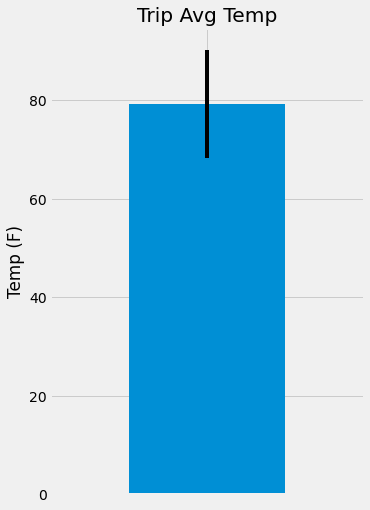

In [56]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Create dataframe with trip_temp data
trip_temps_df = pd.DataFrame(trip_temps, columns = ['TMIN', 'TAVG', 'TMAX'])
trip_temps_df

# Plot the average temp
error = trip_temps_df['TMAX'] - trip_temps_df['TMIN']
trip_temps_df.plot(kind = 'bar', y = 'TAVG', yerr = error, figsize = (5,8), title = 'Trip Avg Temp', legend = '')
plt.ylabel('Temp (F)')
plt.tick_params(axis = 'x', labelbottom = False)
plt.show()

### Daily Rainfall Average

In [63]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station,
       func.sum(Measurement.prcp),
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation]

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

station_data = session.query(*sel).filter(Measurement.station == Station.station, func.strftime(Measurement.date) >= start_date, func.strftime(Measurement.date) <= end_date).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

station_data
                                          

[('USC00516128', 0.36, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00514830', 0.22, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00519281', 0.06, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 0.04, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523', 0.0, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)]

### Daily Temperature Normals

In [22]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
dates = pd.date_range(start_date, end_date).strftime('%Y-%m-%d')
# Strip off the year and save a list of strings in the format %m-%d
trip_dates = pd.date_range(start_date, end_date).strftime('%m-%d')
trip_dates

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []

for date in trip_dates:
    daily_temp_normal = daily_normals(date)[0]
    normals.append(daily_temp_normal)
    
print(normals)

[(67.0, 75.54, 83.0), (68.0, 75.60377358490567, 84.0), (70.0, 76.61111111111111, 85.0), (69.0, 76.71153846153847, 84.0), (69.0, 76.14814814814815, 82.0), (67.0, 76.25, 83.0), (71.0, 77.15686274509804, 83.0)]


In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normals, index = trip_dates, columns = ['TMIN', 'TAVG', 'TMAX'])
normal_df

,TMIN,TAVG,TMAX
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


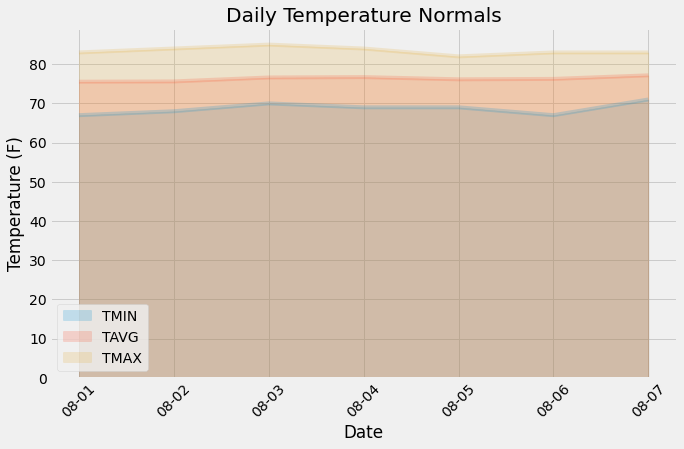

In [44]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot(kind = 'area', stacked = False, alpha = .2, figsize = (10,6))
plt.title('Daily Temperature Normals')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.legend(loc = 'best')
plt.xticks(rotation = 45)
plt.show()

## Close Session

In [45]:
# Close Session
session.close()